## Constructs the ELBO as a function of K plot
Loads the model and output of the specified runs and plots the ELBO as a function of K

In [2]:
import matplotlib
import matplotlib.pyplot as plt
# imports
import scgenome.plotting as pl
import h5py
import anndata
import numpy as np
import sklearn.mixture
import os
import json

Load models, output file and data

In [ ]:
base_path = "../../output/bahlis_10x"
data_path = '../../data/bahlis_10x/patient_MM-04.h5ad'
patient_name = "patient_MM-04"
hyper_params = "L5i100step0p1splitELBOreclusterLambda100kqTTemp500Laris"
K_list = [5, 6, 7, 8, 9, 10, 11, 12]
path = os.path.join(base_path, patient_name)
adata = anndata.read_h5ad(data_path)
out_files = []
models_files = []
config_files = []
for K in K_list:
    hyper_params = f"K{K}" + hyper_params
    path = os.path.join(path, hyper_params)
    out_file = anndata.read_h5ad(os.path.join(path, 'victree.out.h5ad'))
    model_file = h5py.File(os.path.join(path, 'victree.model.h5'))
    out_files.append(out_file)
    models_files.append(model_file)
    with open(os.path.join(path, "victree.config.json")) as file:
        config_file = json.load(file)
    config_files.append(config_file)

Plot ELBOs of all models

In [ ]:
elbos = [out_file.uns['victree-elbo'] for out_file in out_files]
plt.plot(K_list, elbos)

Plot the output of the model with highest ELBO

In [ ]:
best_K = np.argmax(elbos)
out_file = out_files[best_K]
model_file = models_files[best_K]
print(f"Best K: {best_K} with Elbo: {elbos[best_K]}")

In [5]:
# get cell assignment and cell copy number
argmax_qz = out_file.obsm['victree-clone-probs'][...].argmax(axis=1)
clone_cn_np = out_file.layers['victree-cn-marginal'][...].argmax(axis=-1)
cell_cn = clone_cn_np[argmax_qz, :]

In [6]:
chr_codes = {c: c[3:] for c in adata.var['chr'].unique()}
adata.var['chr'] = adata.var['chr'].map(chr_codes)

ELBO: 


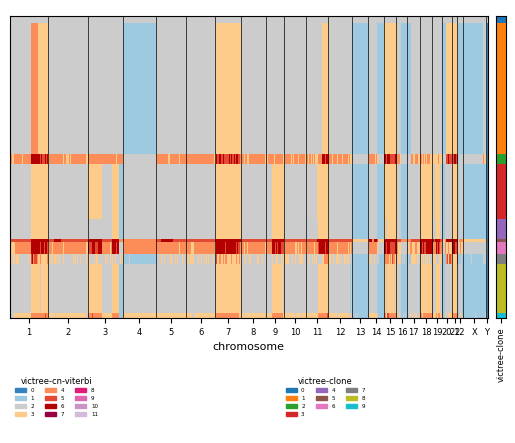

In [7]:
%matplotlib inline
#out_file.layers['victree-cn-marginal'] = cell_qc.get_viterbi()[1:].numpy()
elbo = out_file
print(f"ELBO: {out_file.uns['victree-elbo']}")
g = pl.plot_cell_cn_matrix_fig(out_file, 'victree-cn-viterbi', cell_order_fields=['victree-clone'], annotation_fields=['victree-clone'], max_cn=7)

In [25]:
E_q_mu = out_file.obs['victree-mu']
print(f"E_q[mu] max: {E_q_mu.max()} min: {E_q_mu.min()}")

E_q[mu] max: 1.3645429611206055 min: 0.8936222791671753


In [29]:
adata.obs['victree-clone'] = out_file.obs['victree-clone']

Cluster the HMMCopy using a GMM with same K as VICTree

In [55]:
import sklearn
hmmcopy_gmm_cluster_ids = adata.obs['cluster_id']
n_unique = len(hmmcopy_gmm_cluster_ids.values.unique())

K_list = np.arange(10, 40)
elbo_list = []
hmm_states = adata.layers["state"]
for K in K_list:
    cluster_alg = sklearn.mixture.GaussianMixture(n_components=K, covariance_type="diag", n_init=10)
    cluster_alg.fit(hmm_states)
    labels = cluster_alg.predict(hmm_states)
    elbo_list.append(cluster_alg.lower_bound_)

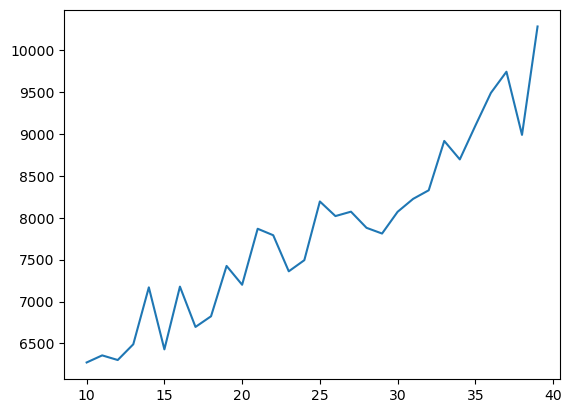

In [56]:
plt.plot(K_list, elbo_list)

In [44]:
import copy
adata_copy = copy.deepcopy(adata)
adata_copy.obs['gmm_cluster_id'] = labels
adata_copy.obs['victree-clone'] = top_z

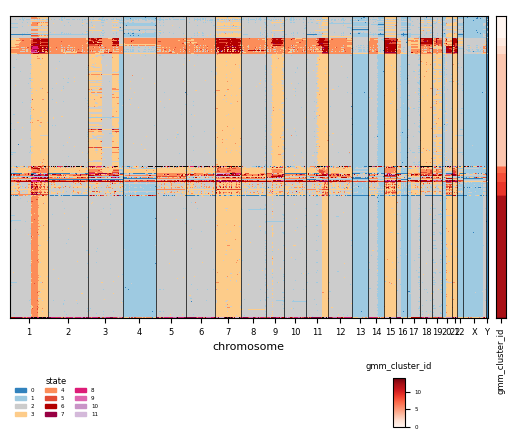

In [50]:
g = pl.plot_cell_cn_matrix_fig(adata_copy, 'state', cell_order_fields=['gmm_cluster_id'], annotation_fields=['gmm_cluster_id'])

<Axes: xlabel='chromosome'>

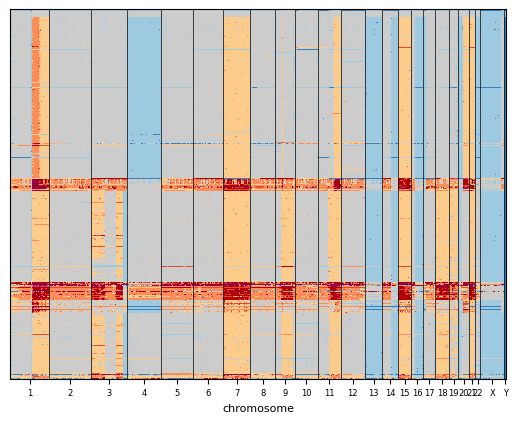

In [46]:
pl.plot_cell_cn_matrix(adata_copy, 'state', cell_order_fields=['clone'], max_cn=7)['ax']

/var/folders/gt/k64xtzx97m9dchpngd2j_xp40000gp/T/ipykernel_19696/4006104823.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(mst, prog="dot")


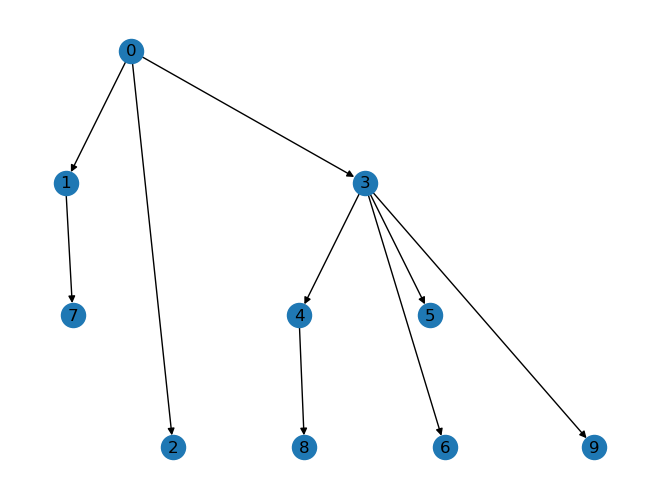

In [30]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
adj_matrix = out_file.uns['victree-tree-graph']
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
mst = nx.maximum_spanning_arborescence(G)
pos = graphviz_layout(mst, prog="dot")
nx.draw(mst, pos=pos, with_labels=True)

In [31]:
qZ_probs = out_file.obsm['victree-clone-probs'][...]
clonal_fractions = np.mean(qZ_probs, axis=0)
print(clonal_fractions)

[0.02186513 0.43377066 0.03600282 0.18194933 0.06434128 0.01193638
 0.036846   0.0348762  0.16248968 0.01592263]


In [32]:
import numpy as np
np.unique(top_z, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 22, 435,  36, 182,  65,  12,  37,  35, 163,  16]))

In [33]:
out_file['result']['trees'].keys()

KeyError: 'result'

In [ ]:

for t in zip(out_file['result']['trees']['newick'], out_file['result']['trees']['weight']):
    print(t[0])
    print(t[1])
    print('---')